In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid and space SEPP

We use a grid based histogram to estimate the background rate, but a "full" trigger, now from KDE.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import open_cp.data
import open_cp.sources.sepp as source_sepp
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout("open_cp")
import open_cp.kernels
import sepp.sepp_grid
import sepp.sepp_grid_space
import sepp.kernels
#import scipy.integrate

## The background sampler we'll use

In [3]:
class GridPoissonSampler(source_sepp.Sampler):
    def __init__(self, grid, rates, clustered=False):
        self._grid = grid
        self._rates = np.asarray(rates)
        assert (grid.yextent, grid.yextent) == self._rates.shape
        self._clustered = clustered
    
    def sample(self, start_time, end_time):
        points = []
        dt = end_time - start_time
        event_counts = np.random.poisson(dt * self._rates)
        for i in range(event_counts.shape[0]):
            for j in range(event_counts.shape[1]):
                times = np.random.random(event_counts[i,j]) * dt + start_time
                if self._clustered:
                    xcs = (0.4 + 0.2 * np.random.random(event_counts[i,j])) * self._grid.xsize
                    ycs = (0.4 + 0.2 * np.random.random(event_counts[i,j])) * self._grid.ysize
                else:
                    xcs = np.random.random(event_counts[i,j]) * self._grid.xsize
                    ycs = np.random.random(event_counts[i,j]) * self._grid.ysize
                xcs += self._grid.xoffset + j * self._grid.xsize
                ycs += self._grid.yoffset + i * self._grid.ysize
                for t, x, y in zip(times, xcs, ycs):
                    points.append([t,x,y])
        points = np.asarray(points).T
        return self._order_by_time(points)

In [4]:
grid = sepp.sepp_grid.ConcreteBoundedGrid(50, 50, 0, 0, 10, 10)
rates = np.random.random(size=(10,10)) / 10
bk_sampler = GridPoissonSampler(grid, rates)
tr_sampler = source_sepp.InhomogeneousPoissonFactors(source_sepp.Exponential(10, 0.5),
                source_sepp.GaussianSpaceSampler([0,0], [2,2], 0))
simulate = source_sepp.SelfExcitingPointProcess(bk_sampler, tr_sampler)

In [5]:
details = simulate.sample_with_details(0, 365)

## Triggering

Seems exponential in time and Gaussian in space, as expected

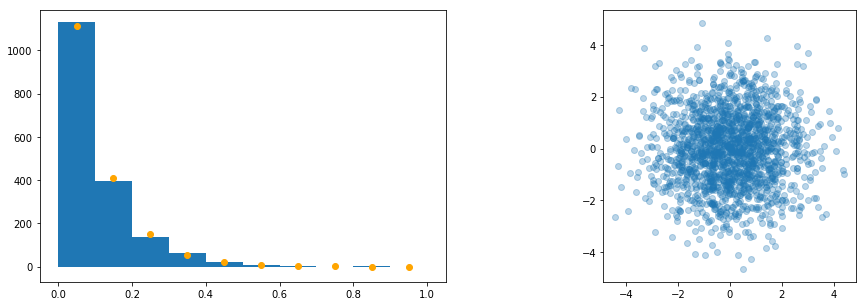

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

axes[0].hist(details.trigger_deltas[0], bins=np.linspace(0,1,11))
x = np.linspace(0,1,11)
y = details.trigger_deltas.shape[1] * (np.exp(-10*x)[:-1] - np.exp(-10*x)[1:])
x += (x[1] - x[0])/2
axes[0].scatter(x[:-1], y, color="orange", zorder=10)
axes[1].scatter(*details.trigger_deltas[1:,], alpha=0.3)
axes[1].set_aspect(1)
None

In [7]:
print("Estimated omega =",
    1 / np.mean(details.trigger_deltas[0]) )
print("Estimated sigma^2 =",
    np.sum(details.trigger_deltas[1:]**2) / (2 * details.trigger_deltas.shape[1]) )

Estimated omega = 10.0542806946
Estimated sigma^2 = 2.03084249589


## Background

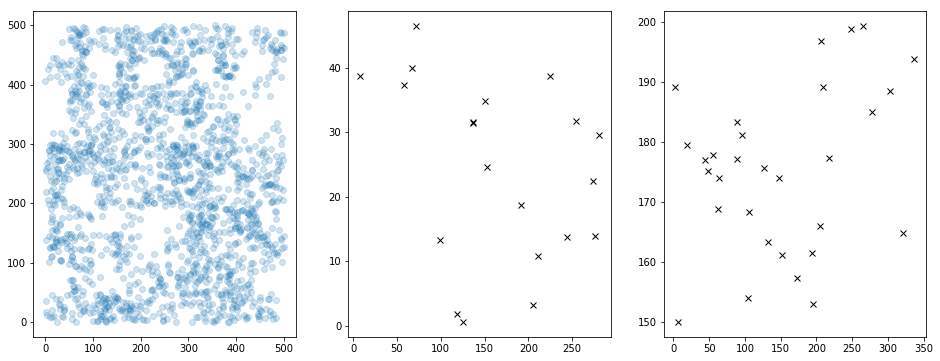

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(16,6))

xcs = details.backgrounds[1]
ycs = details.backgrounds[2]
axes[0].scatter(xcs, ycs, alpha=0.2)

m = (xcs < 50) & (ycs < 50)
times = details.backgrounds[0][m]
axes[1].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

m = (xcs > 150) & (xcs < 200) & (ycs < 50)
times = details.backgrounds[0][m]
axes[2].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

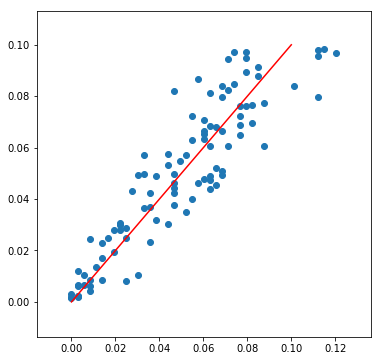

In [9]:
xg = np.floor(details.backgrounds[1] / 50).astype(np.int)
yg = np.floor(details.backgrounds[2] / 50).astype(np.int)
mu = np.zeros_like(rates)
for x, y in zip(xg, yg):
    mu[y,x] += 1
mu /= 365
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(mu.flatten(), rates.flatten())
ax.plot([0,0.1], [0,0.1], color="red")
None

## Combined

In [10]:
points = details.points

m = (points[1] >= 0) & (points[1] < 500) & (points[2] >= 0) & (points[2] < 500)
points = points[:,m]
points.shape, details.points.shape

((3, 3541), (3, 3555))

In [11]:
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))
timed_points = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1),
    time_unit)
timed_points.time_range

(numpy.datetime64('2017-01-01T02:01:43.868'),
 numpy.datetime64('2017-12-31T23:05:57.630'))

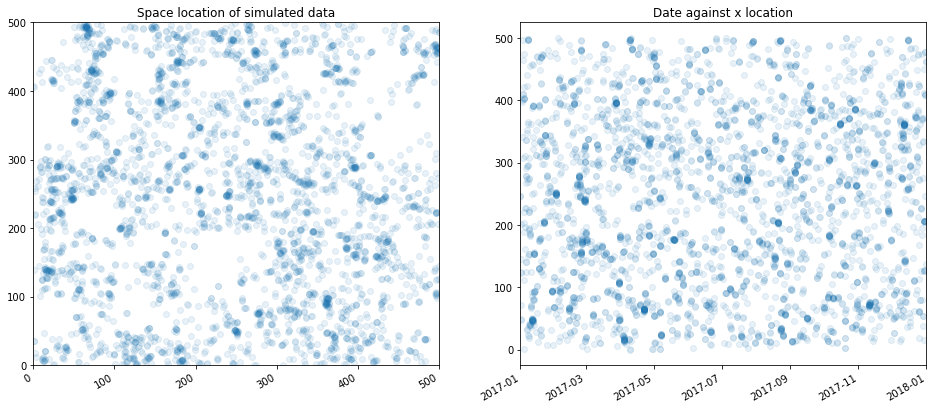

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.1)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,500], ylim=[0,500])

times = timed_points.times_datetime()
ax[1].scatter(times, timed_points.xcoords, alpha=0.1)
ax[1].set_xlim([datetime.datetime(2017,1,1), datetime.datetime(2018,1,1)])
ax[1].set_title("Date against x location")
fig.autofmt_xdate()
None

# Fit

In [16]:
tkp = sepp.kernels.FixedBandwidthKernelProvider(0.1, cutoff=2)
skp = sepp.kernels.FixedBandwidthKernelProvider(1, cutoff=5)
trainer = sepp.sepp_grid_space.Trainer4(grid, tkp, skp, initial_time_scale=5, initial_space_scale=1)
trainer.data = timed_points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
model

Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.5, time=<function Trainer4.initial_model.<locals>.tk at 0x00000216BED88268>, space=<function Trainer4.initial_model.<locals>.sk at 0x00000216BED88488>

In [17]:
for _ in range(10):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
    print(model)

Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49250559649924047, time=<open_cp.kernels.Reflect1D object at 0x00000216BF485128>, space=<open_cp.kernels.GaussianBase object at 0x00000216BF4854E0>
Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49522312842914934, time=<open_cp.kernels.Reflect1D object at 0x00000216BF4C3588>, space=<open_cp.kernels.GaussianBase object at 0x00000216BF4C3438>
Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49529987726423064, time=<open_cp.kernels.Reflect1D object at 0x00000216BF4C3358>, space=<open_cp.kernels.GaussianBase object at 0x00000216BF4C35C0>
Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49535098466316857, time=<open_cp.kernels.Reflect1D object at 0x00000216BF4C34A8>, space=<open_cp.kernels.GaussianBase object at 0x00000216BF4C3BE0>
Mode

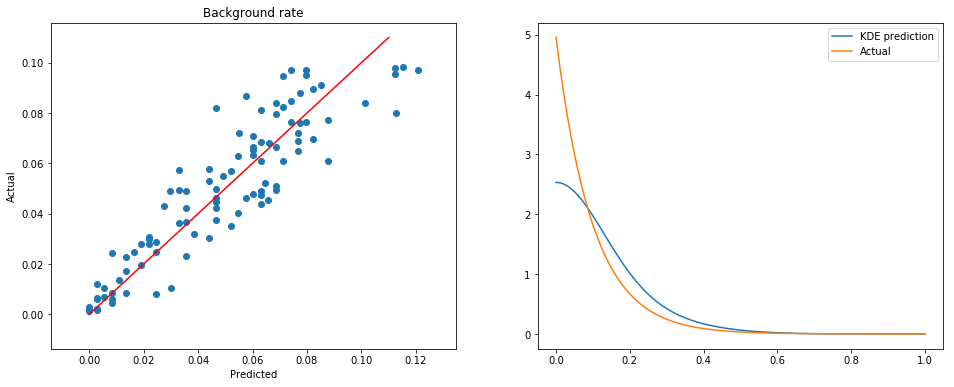

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

ax = axes[0]
ax.scatter(model.mu.flatten() * grid.xsize * grid.ysize, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")

ax = axes[1]
x = np.linspace(0, 1, 100)
ax.plot(x, model.time_kernel(x) * model.theta, label="KDE prediction")
y = 10 * np.exp(-10 * x)
ax.plot(x, y * model.theta, label="Actual")
ax.legend()
None

In [22]:
x = np.linspace(-5, 5, 101)
y = np.linspace(-5, 5, 101)
xcs, ycs = np.meshgrid(x, y)
z = model.space_kernel([xcs.flatten(), ycs.flatten()])
z = z.reshape(xcs.shape)
def func(pt):
    rs = pt[0]**2 + pt[1]**2
    return np.exp(-rs/8) / (2 * np.pi * 4)
zz = func([xcs.flatten(), ycs.flatten()]).reshape(xcs.shape)

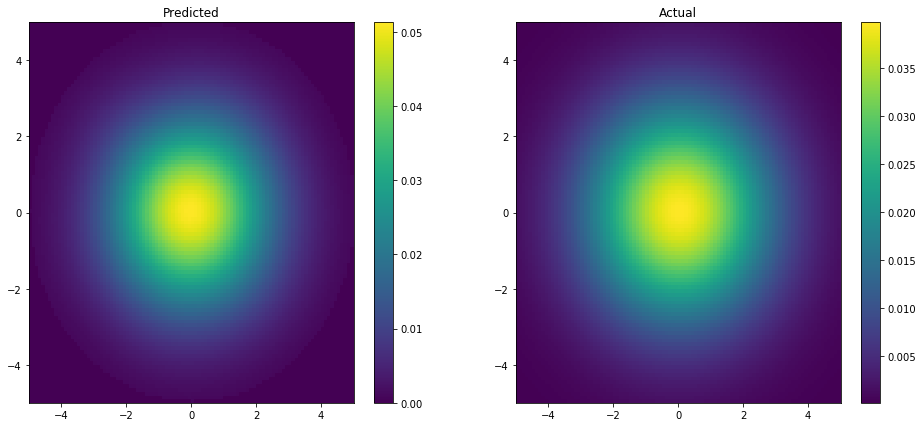

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(16,7))

ax = axes[0]
m = ax.pcolormesh(x, y, z)
fig.colorbar(m, ax=ax)
ax.set_title("Predicted")

ax = axes[1]
m = ax.pcolormesh(x, y, zz)
fig.colorbar(m, ax=ax)
ax.set_title("Actual")
None

# Stochastic EM algorithm

Faster, and on this data, equally as good

In [26]:
tkp = sepp.kernels.FixedBandwidthKernelProvider(0.1, cutoff=1)
skp = sepp.kernels.FixedBandwidthKernelProvider(1, cutoff=5)
trainer = sepp.sepp_grid_space.Trainer4a(grid, tkp, skp, initial_time_scale=5, initial_space_scale=1)
trainer.data = timed_points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
model

Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.5, time=<function Trainer4.initial_model.<locals>.tk at 0x00000216C2DB48C8>, space=<function Trainer4.initial_model.<locals>.sk at 0x00000216C2DC6A60>

In [27]:
for _ in range(10):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
    print(model)

Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49250559649924047, time=<open_cp.kernels.Reflect1D object at 0x00000216865269B0>, space=<open_cp.kernels.GaussianBase object at 0x0000021686526BA8>
Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49499782178893637, time=<open_cp.kernels.Reflect1D object at 0x00000216865267F0>, space=<open_cp.kernels.GaussianBase object at 0x0000021686526048>
Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4949827111742718, time=<open_cp.kernels.Reflect1D object at 0x0000021686526A58>, space=<open_cp.kernels.GaussianBase object at 0x00000216865260B8>
Model4(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49497668101455483, time=<open_cp.kernels.Reflect1D object at 0x00000216865267F0>, space=<open_cp.kernels.GaussianBase object at 0x00000216BF491E10>
Model

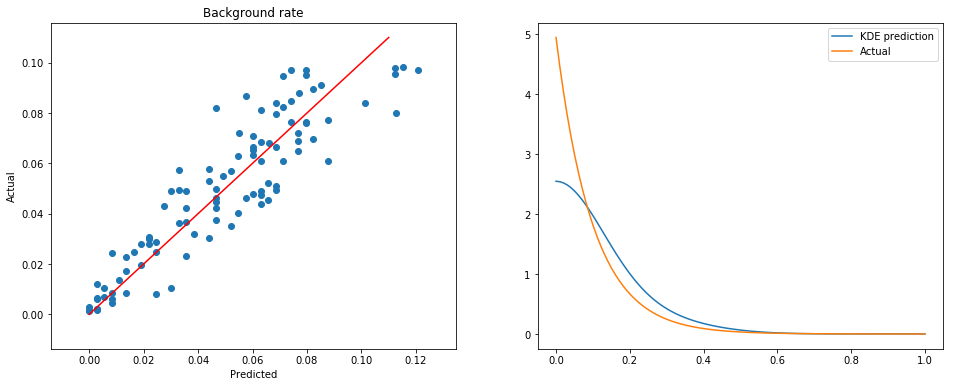

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

ax = axes[0]
ax.scatter(model.mu.flatten() * grid.xsize * grid.ysize, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")

ax = axes[1]
x = np.linspace(0, 1, 100)
ax.plot(x, model.time_kernel(x) * model.theta, label="KDE prediction")
y = 10 * np.exp(-10 * x)
ax.plot(x, y * model.theta, label="Actual")
ax.legend()
None

In [29]:
x = np.linspace(-5, 5, 101)
y = np.linspace(-5, 5, 101)
xcs, ycs = np.meshgrid(x, y)
z = model.space_kernel([xcs.flatten(), ycs.flatten()])
z = z.reshape(xcs.shape)
def func(pt):
    rs = pt[0]**2 + pt[1]**2
    return np.exp(-rs/8) / (2 * np.pi * 4)
zz = func([xcs.flatten(), ycs.flatten()]).reshape(xcs.shape)

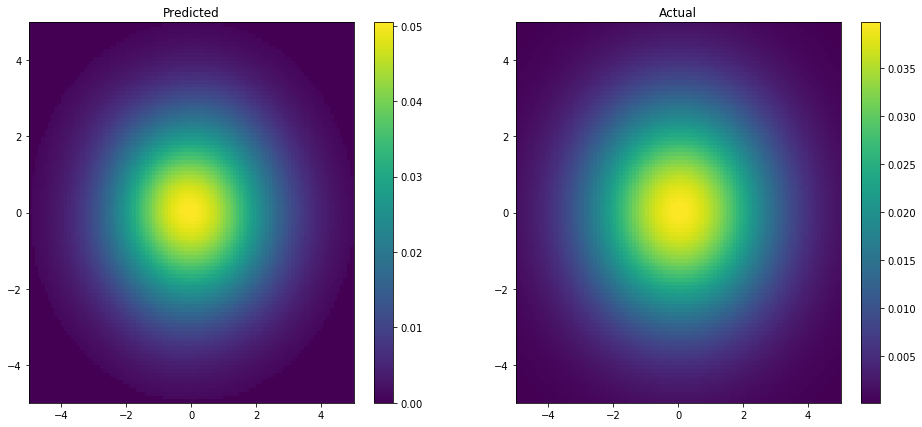

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(16,7))

ax = axes[0]
m = ax.pcolormesh(x, y, z)
fig.colorbar(m, ax=ax)
ax.set_title("Predicted")

ax = axes[1]
m = ax.pcolormesh(x, y, zz)
fig.colorbar(m, ax=ax)
ax.set_title("Actual")
None

# Joint KDE

In [54]:
# Works okay, but time kernel is over smoothed
#kp = sepp.kernels.FixedBandwidthKernelProvider(1, scale=(0.1,1,1), cutoff=5)

# Better for time, but space becomes somewhat noisy
#kp = sepp.kernels.FixedBandwidthKernelProvider(0.2, scale=(0.1,1,1), cutoff=5)

kp = sepp.kernels.FixedBandwidthKernelProvider(0.5, scale=(0.02,1,1), cutoff=5)

trainer = sepp.sepp_grid_space.Trainer5(grid, kp, initial_time_scale=5, initial_space_scale=1)
trainer.data = timed_points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
model

Model5(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.5, trigger=<function Trainer5.initial_model.<locals>.ker at 0x00000216865D66A8>

In [55]:
for _ in range(10):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
    print(model)

Model5(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.49250559649924047, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000216C1411F98>
Model5(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4958689535960025, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000216C13F8E80>
Model5(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4962972510769363, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000216864E6EF0>
Model5(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4964190671543431, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000216C1411F98>
Model5(mu size=(10, 10), T=364.91546449074076, grid=RectangularRegion( (0,0) -> (500,500) ), theta=0.4964258459434858, trigger=<open_cp.kernels.ReflectedKernel object at 0x00000216867A2470>
Model5(mu size=(10, 10), T=364.91546449074076, gr

In [56]:
xy_marginal = sepp.kernels.compute_space_marginal(model.trigger_kernel)
t_marginal = sepp.kernels.compute_t_marginal(model.trigger_kernel)

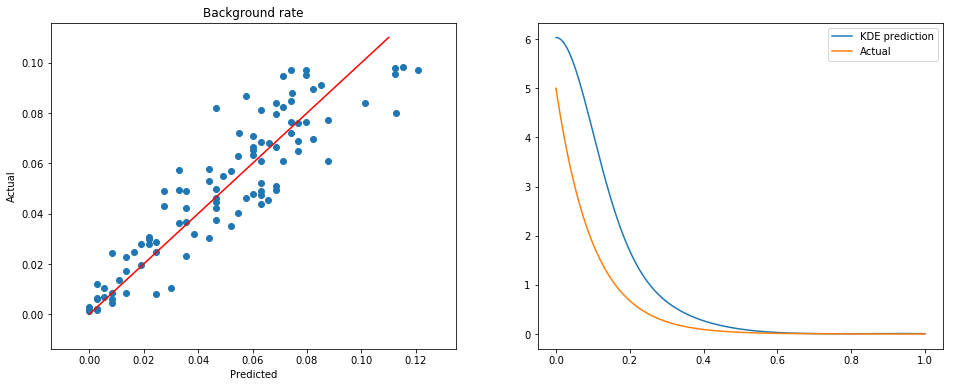

In [57]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

ax = axes[0]
ax.scatter(model.mu.flatten() * grid.xsize * grid.ysize, rates.flatten())
ax.plot([0,0.11], [0,0.11], color="red")
ax.set(xlabel="Predicted", ylabel="Actual", title="Background rate")

ax = axes[1]
x = np.linspace(0, 1, 200)
y = t_marginal(x) + t_marginal(-x)
ax.plot(x, np.asarray(y) * model.theta, label="KDE prediction")
yy = 10 * np.exp(-10 * x)
ax.plot(x, yy * 0.5, label="Actual")
ax.legend()
None

In [58]:
x = np.linspace(-5, 5, 101)
y = np.linspace(-5, 5, 101)
xcs, ycs = np.meshgrid(x, y)
z = xy_marginal([xcs.flatten(), ycs.flatten()])
z = z.reshape(xcs.shape)

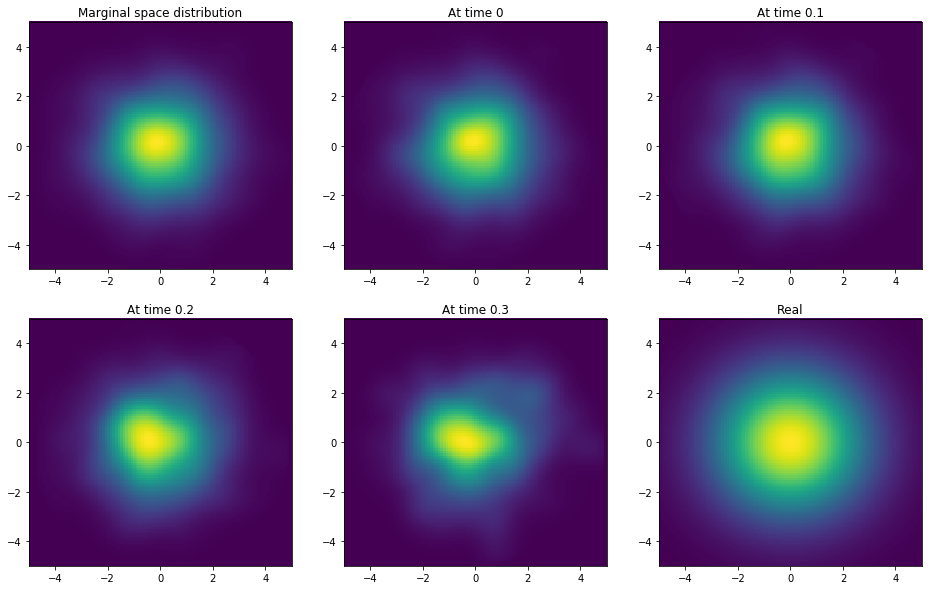

In [59]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,10))

ax = axes.flatten()[0]
ax.pcolorfast(x,y,z)
ax.set_title("Marginal space distribution")

xx = np.linspace(-5, 5, 101)
yy = np.linspace(-5, 5, 101)
xcs, ycs = np.meshgrid(xx, yy)
for ax, time in zip(axes.flatten()[1:], [0, 0.1, 0.2, 0.3, 0.4]):
    zz = model.trigger_kernel([[time] * xcs.flatten().shape[0], xcs.flatten(), ycs.flatten()])
    zz = zz.reshape(xcs.shape)
    ax.pcolorfast(xx,yy,zz)
    ax.set_title("At time {}".format(time))
    
ax = axes.flatten()[5]
def func(pt):
    rs = pt[0]**2 + pt[1]**2
    return np.exp(-rs/8) / (2 * np.pi * 4)
zz = func([xcs.flatten(), ycs.flatten()]).reshape(xcs.shape)
ax.pcolorfast(xx,yy,zz)
ax.set_title("Real")